### Experimenting with SimpleRNN from https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

In [1]:
import numpy as np
import tensorflow as tf

inputs = np.random.random([32, 10, 8]).astype(np.float32)

np.set_printoptions(precision=2)
inputs[0]

array([[0.07, 0.04, 0.75, 0.56, 0.9 , 0.76, 0.87, 0.2 ],
       [0.38, 0.34, 0.03, 0.64, 0.41, 0.09, 0.77, 0.55],
       [0.73, 0.02, 0.39, 0.07, 0.36, 0.93, 0.61, 0.93],
       [0.88, 0.45, 0.63, 0.26, 0.96, 0.71, 0.61, 0.81],
       [0.33, 0.46, 0.54, 0.88, 0.18, 0.16, 0.61, 0.55],
       [0.3 , 0.42, 0.25, 0.47, 0.57, 0.08, 0.75, 0.87],
       [0.98, 0.69, 0.17, 0.04, 0.04, 0.94, 0.13, 0.6 ],
       [0.49, 0.14, 0.05, 0.69, 0.32, 0.55, 0.72, 0.62],
       [0.32, 0.87, 0.61, 0.62, 0.22, 0.93, 0.15, 0.14],
       [0.23, 0.66, 0.37, 0.44, 0.94, 0.32, 0.2 , 0.42]], dtype=float32)

In [2]:
inputs.shape

(32, 10, 8)

In [3]:
simple_rnn = tf.keras.layers.SimpleRNN(4)

output = simple_rnn(inputs)  # The output has shape `[32, 4]`.
print('output.shape =', output.shape)

simple_rnn = tf.keras.layers.SimpleRNN(4, return_sequences=True, return_state=True)

# whole_sequence_output has shape `[32, 10, 4]`.
# final_state has shape `[32, 4]`.
whole_sequence_output, final_state = simple_rnn(inputs)
print('whole_sequence_output.shape =', whole_sequence_output.shape)
print('final_state.shape =', final_state.shape)

output.shape = (32, 4)
whole_sequence_output.shape = (32, 10, 4)
final_state.shape = (32, 4)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from IPython.display import display

In [5]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(None, 2), activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10)                130       
                                                                 
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


,0
0,0.002643
1,0.043313
2,-0.051820
3,0.004774
4,0.124522


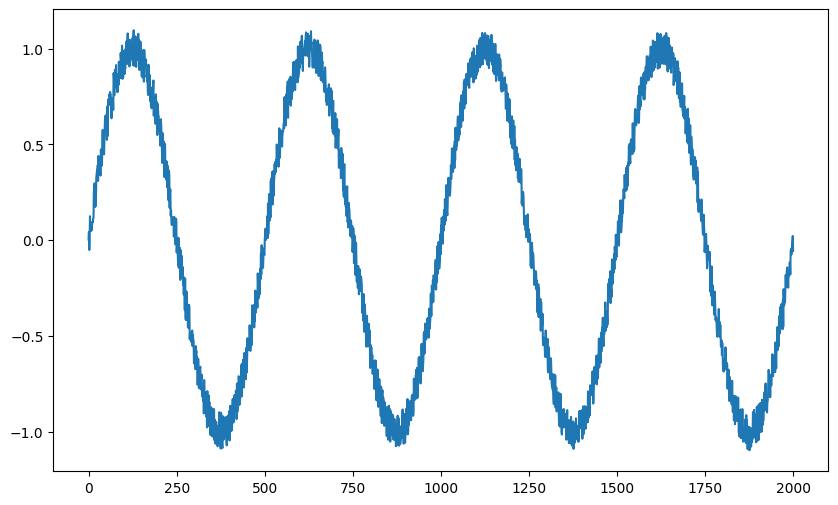

In [6]:
n_samples = 10000
n_periods = 20
phase_value = n_samples // n_periods

noise_scale = 0.2
t = np.arange(0, n_samples)
x = np.sin(2*np.pi*t/phase_value) + noise_scale * (np.random.rand(n_samples)-0.5) # + np.sin(0.5*t/phase_value)
df = pd.DataFrame(x)
display(df.head())

plt.subplots(figsize=(10, 6))
plt.plot(df[:2000])
plt.show()

In [7]:
split_test_partition = int(0.8*n_samples)
train, test = df.values[0:split_test_partition, :], df.values[split_test_partition:, :]

#### Create a Sequence Data

In [8]:
window_size = 10

def sequenceData(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size):
        d = i + window_size
        X.append(data[i:d, ])
        y.append(data[d, ])
    return np.array(X), np.array(y)

X_train, y_train = sequenceData(train, window_size)
X_test, y_test = sequenceData(test, window_size)

In [9]:
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

In [10]:
model = Sequential()
model.add(SimpleRNN(units=16, input_shape=(None, 1), activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1))

lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_rate=1e-6, decay_steps=1, staircase=False)
opt = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 16)                288       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 7s 18ms/step - loss: 0.0814 - val_loss: 0.0058
Epoch 2/10
250/250 [==============================] - 4s 17ms/step - loss: 0.0105 - val

63/63 [==============================] - 0s 5ms/step


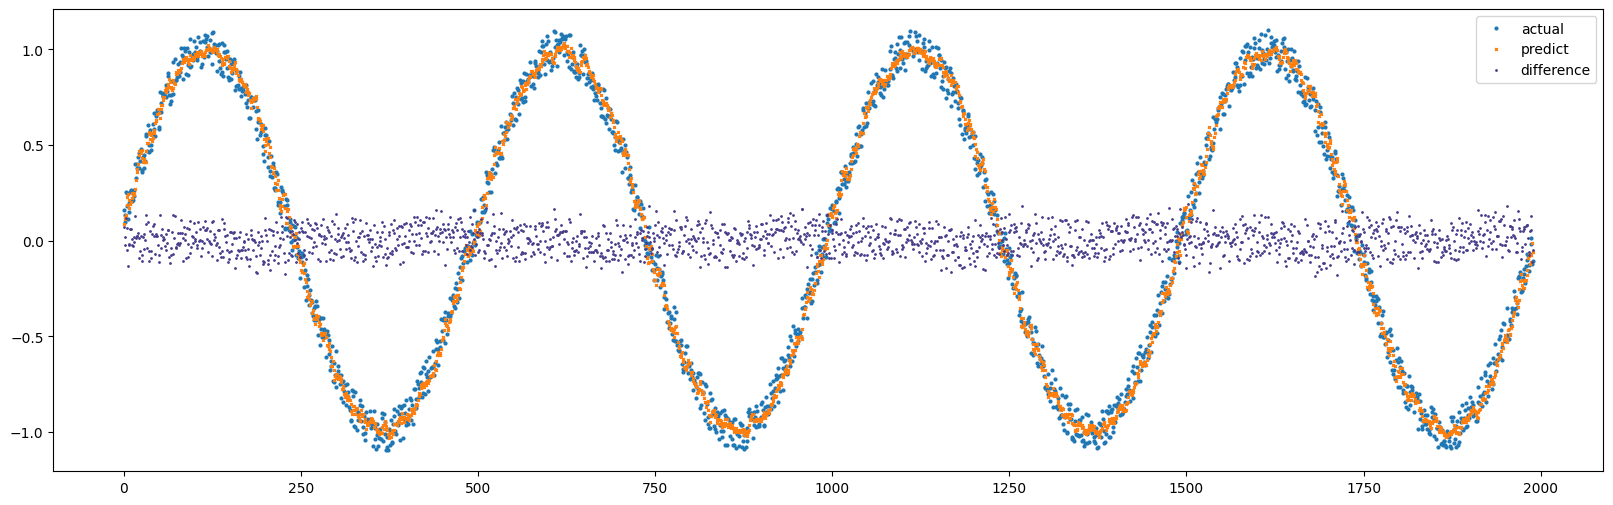

In [11]:
y_pred = model.predict(X_test)

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(y_test, 'o', markersize=2, label='actual')
plt.plot(y_pred, 'x', markersize=2, label='predict')
plt.plot(y_test - y_pred, '.', markersize=2, label='difference', color='darkslateblue')
ax.legend(loc='best')
plt.show()